In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import sys
# import os

# parent = os.getcwd().split("/DESI-QA/")[0] 
# root = f"{parent}/DESI-QA"

# try:
#     sys.path.append(f"{parent}/desiarc/arc")
#     import find_center as fc
# except:
#     sys.path.append(f"{root}/desiarc-main/arc")
#     import find_center as fc
    
# sys.path.append(f"{root}/")
# sys.path.append(f"{root}/output/figures/")
# from spotfinder import spotfinder
# from xylib import calc_movetables as cm

# plt.rcParams.update({'figure.dpi':120})

import reportlib as rl

In [116]:
import importlib
importlib.reload(rl)
figPath = rl.figPath

In [117]:
# Prepare different databases
db = pd.read_csv("../output/database.csv")
rl.get_timecol(db)

fiddb = pd.read_csv("../output/fiddb.csv")
rl.get_timecol(fiddb)

testStart = np.datetime64('2023-06-27 10:40:00')
testFinish = testStart + np.timedelta64(1,"h")

In [8]:

# Because query_time uses label (not mvlabel or move), if initial selection is OK, then you can
# join using db.insert(len(db.columns))
mask1 = rl.query_time(db, datemin=testStart,datemax=testFinish)
mask2 = rl.query_time(fiddb, datemin=testStart,datemax=testFinish)

# Creating masks
df = db[mask1].reset_index(drop=True)
fiddf = fiddb[mask2].reset_index(drop=True)

# Inserting pix2mm and sigpix2mm
if rl.aligned(df,'move',fiddf,'mvlabel'):
    df.insert(len(df.columns),"fid x0",fiddf['x0'])
    df.insert(len(df.columns),"fid y0",fiddf['y0'])
    df.insert(len(df.columns),"fid x1",fiddf['x1'])
    df.insert(len(df.columns),"fid y1",fiddf['y1'])
    df.insert(len(df.columns),"fid x2",fiddf['x2'])
    df.insert(len(df.columns),"fid y2",fiddf['y2'])
    df.insert(len(df.columns),"fid x3",fiddf['x3'])
    df.insert(len(df.columns),"fid y3",fiddf['y3'])
    df.insert(len(df.columns),"pix2mm",fiddf['pix2mm'])
    df.insert(len(df.columns),"sigpix2mm",fiddf['sigpix2mm'])
    del fiddf
else:
    print("Movelabels are not aligned - inspect your movelabels and try again")

# Find sessions for each arcsequence
sessions = rl.getSessions(df)

# Make an arcnum session column and add it to the df
sessionLabels = rl.makeSessionLabels(sessions)

# Add session labels to the df
df.insert(len(df.columns),'ArcSession',sessionLabels)

#Find centers for each arcsequence
xc2_arr, yc2_arr, R2_arr, xc2_pix_arr, yc2_pix_arr = rl.phi_centers(df,sessions)

# Store centers in df
df.insert(len(df.columns),'xc2 mm',xc2_arr)
df.insert(len(df.columns),'yc2 mm',yc2_arr)
df.insert(len(df.columns),'R2 mm',R2_arr)
df.insert(len(df.columns),'xc2 pix',xc2_pix_arr)
df.insert(len(df.columns),'yc2 pix',yc2_pix_arr)

# Calculate x and y positions in mm
x_mm = df['xpix']*df['pix2mm']
y_mm = df['ypix']*df['pix2mm']

# Insert x and y positions to df
df.insert(12,'x mm',x_mm)
df.insert(13,'y mm',y_mm)

# Insert mount config into df in string form
df.insert(len(df.columns),'Mount Configuration',rl.set_MountConfig_String(df))

# Compute alpha individually
alpha_arr, req_arr, obs_arr = rl.getAlphas(df)

# Insert alpha to df
df.insert(len(df.columns),'Alpha',alpha_arr)
df.insert(len(df.columns),'Requested Move',req_arr)
df.insert(len(df.columns),'Observed Move',obs_arr)

# Compute mean and std of alpha of each session
mean_alpha_session,std_alpha_session, mean_alpha, std_alpha= rl.getMeans(df)

# Insert alpha session mean and std to df
df.insert(len(df.columns),'Mean Alpha',mean_alpha_session)
df.insert(len(df.columns),'Std Alpha',std_alpha_session)

In [12]:
MountConfigs = np.unique(df['Mount Configuration'])
MountConfigs = [MountConfigs[1],MountConfigs[0],MountConfigs[2]] # REORDER TO GET THE CONFIGS IN CHRONOLOGICAL ORDER
colors = ['red','blue','green']
legendloc=0
title = "Fiducial Drift of 50 Iterations with 3 mount configurations"
save=False

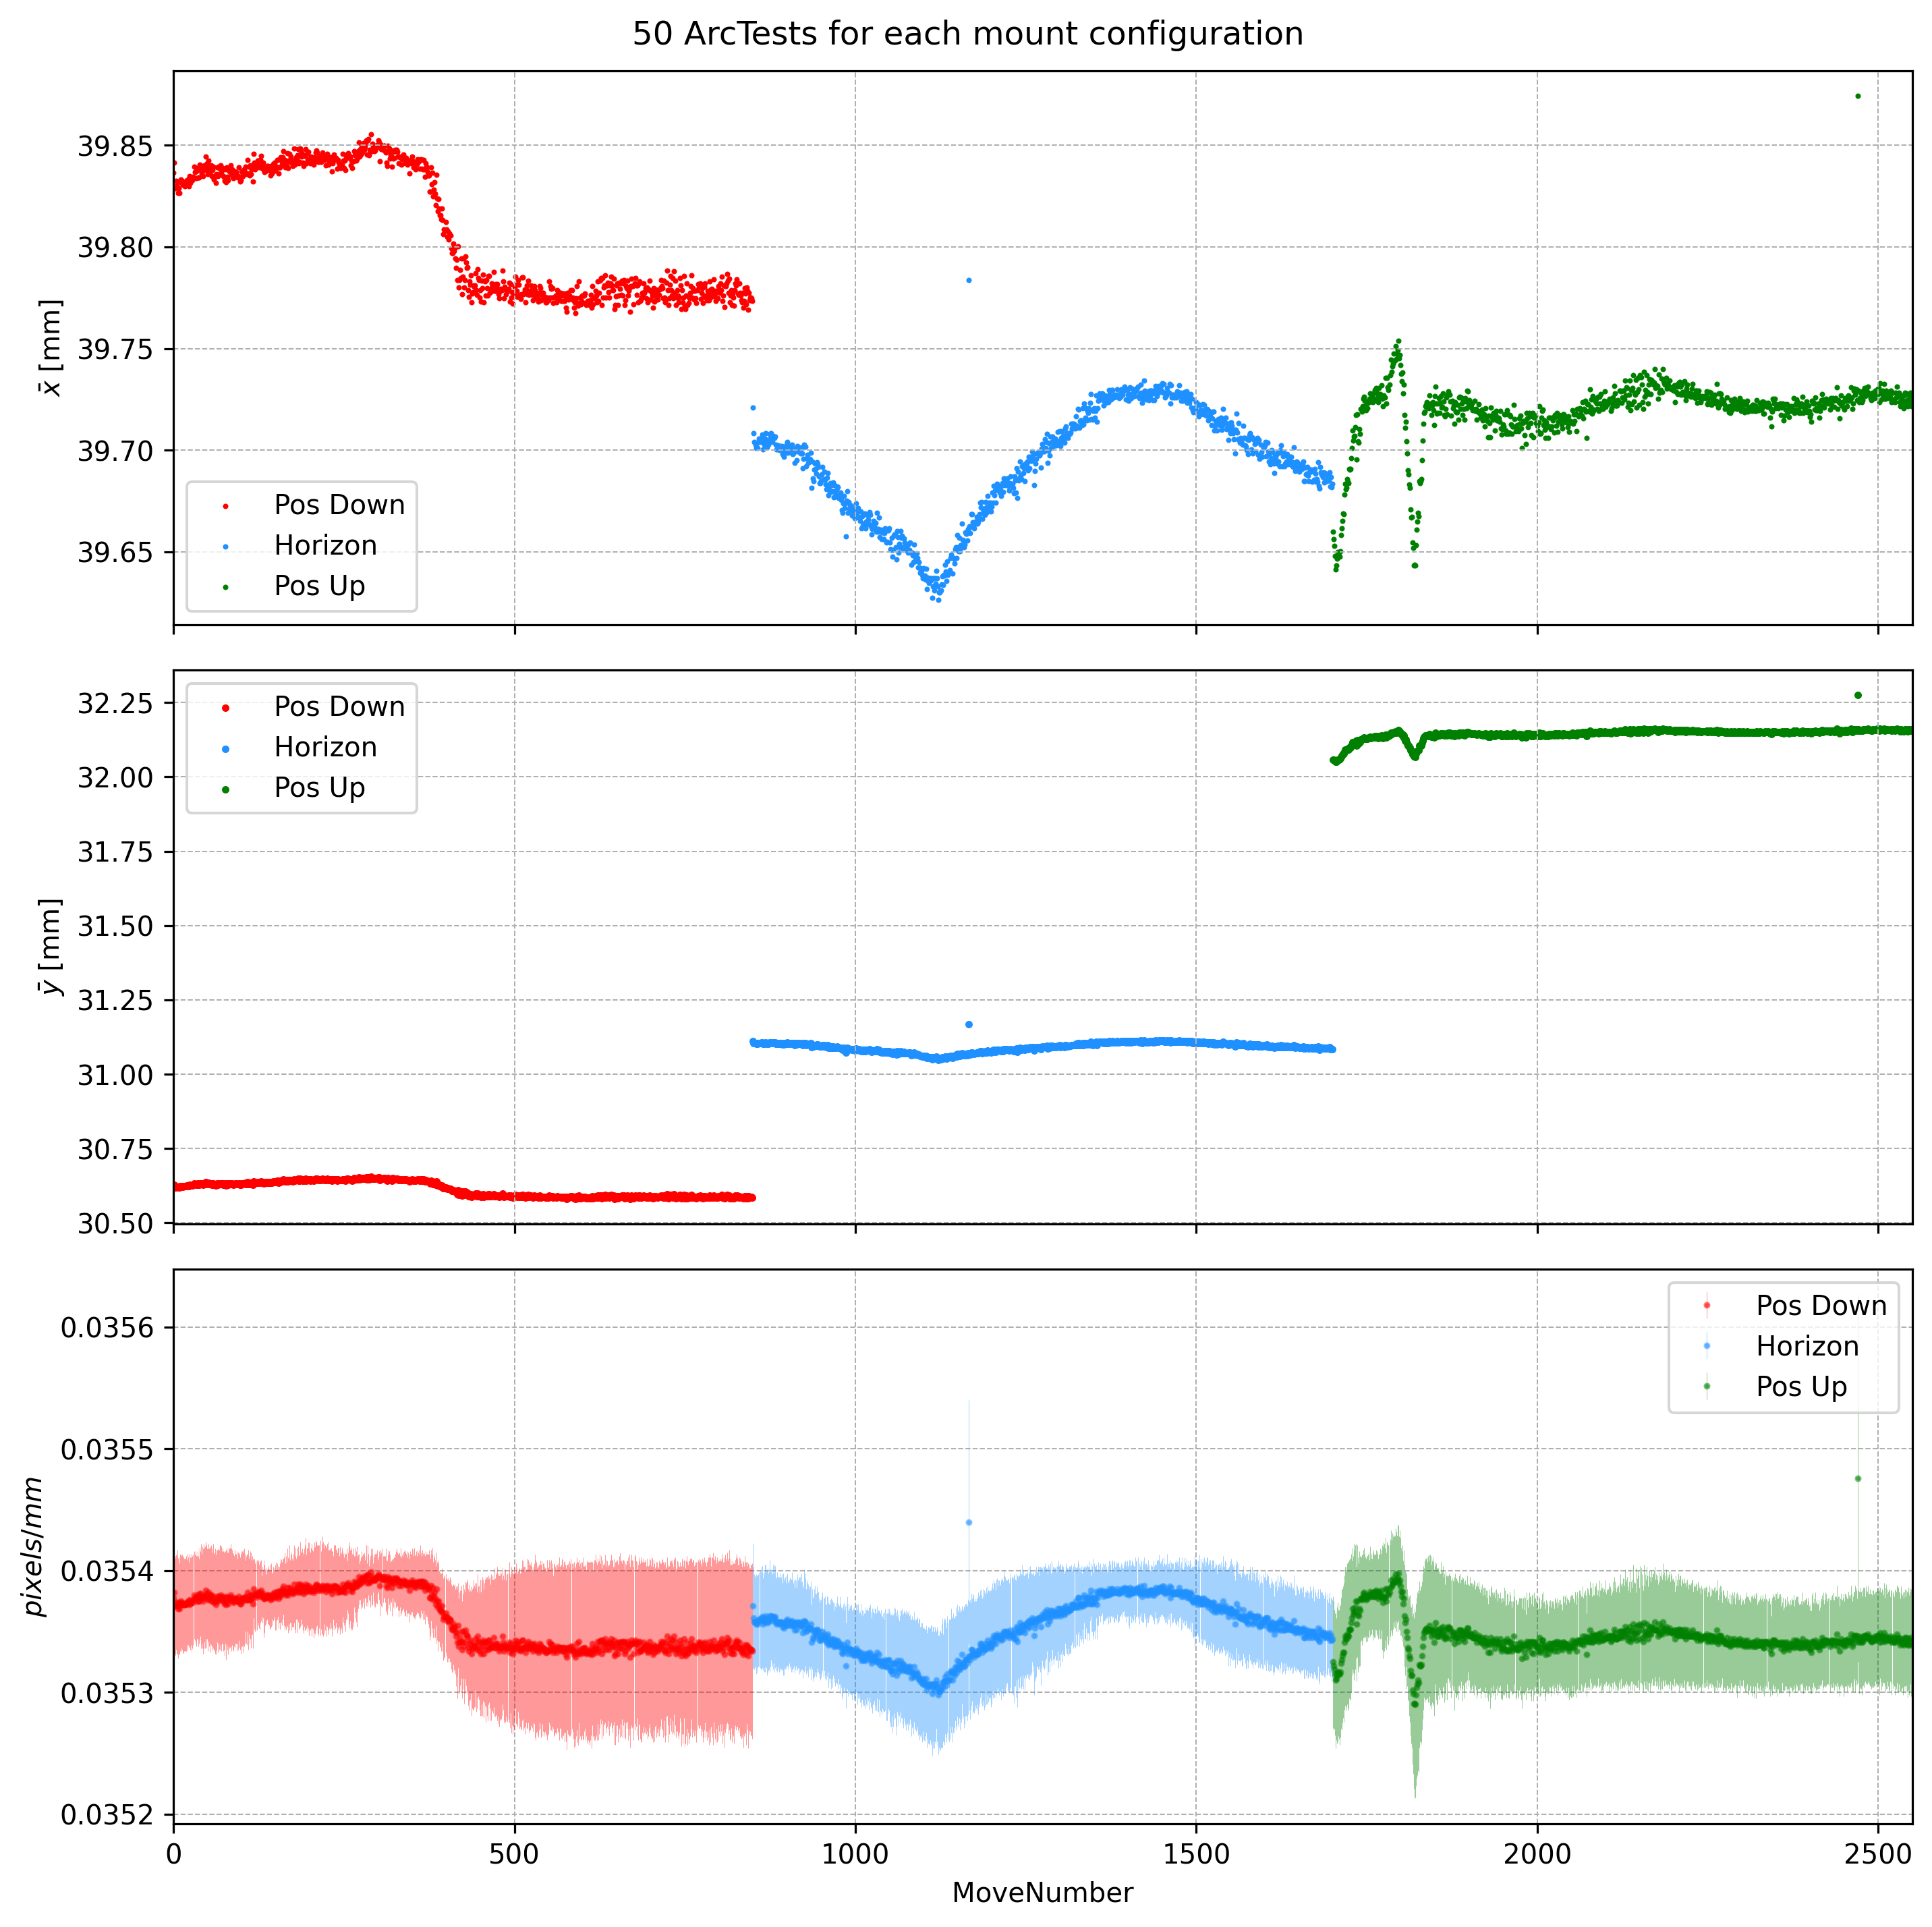

In [197]:
fig,axs = plt.subplots(3,1,figsize=[10,10],dpi=290,sharex=True)

fig.suptitle(title)

# First row - mean x fiducial position
init = 0
for j in range(len(MountConfigs)):
    axs[0].scatter(np.arange(init,len(df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[17]])+init),
             df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[[17,19,21,23]]].mean(axis=1)*df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'],
             color=colors[j],label=MountConfigs[j],s=1)
    init+=len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])
axs[0].set_ylabel(r'$\bar{x}$ [mm]')
axs[0].set_xlim(0,len(df))

# Second row - mean y fiducial position
init = 0
for j in range(len(MountConfigs)):
    axs[1].scatter(np.arange(init,len(df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[18]])+init),
             df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[[18,20,22,24]]].mean(axis=1)*df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'],
             color=colors[j],label=MountConfigs[j],s=3)
    init+=len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])
axs[1].set_ylabel(r'$\bar{y}$ [mm]')
axs[1].set_xlim(0,len(df))

# Third row - pix/mm and sig pix/mm errorbar fig
init = 0
for j in range(len(MountConfigs)):
    axs[2].errorbar(np.arange(init,len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])+init),
             df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'],
             yerr=df[df['Mount Configuration']==MountConfigs[j]]['sigpix2mm'],color=colors[j],
             label=MountConfigs[j],capsize=0, fmt='.',elinewidth=.2,markersize=3, alpha=0.5)
    init+=len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])
axs[2].set_ylabel(r'$pixels / mm$')
axs[2].set_xlabel('MoveNumber')
axs[2].set_xlim(0,len(df))
for i in range(3):
    axs[i].grid(linestyle='--',linewidth=0.5)
    axs[i].legend(loc=legendloc)
    
fig.tight_layout()
    
if save:
    plt.savefig(figPath+title+'.jpg',dpi=180)

plt.show()

# 2

In [57]:
niter = 50

save= False
title = '50 ArcTests for each mount configuration'

Transitions = np.array(['Positioner Down',"Horizon","Positioner Up"])
Transition_colors = np.array(['red','blue','green'])
pointmarkers = ["v",'o','^']
markersize = 25

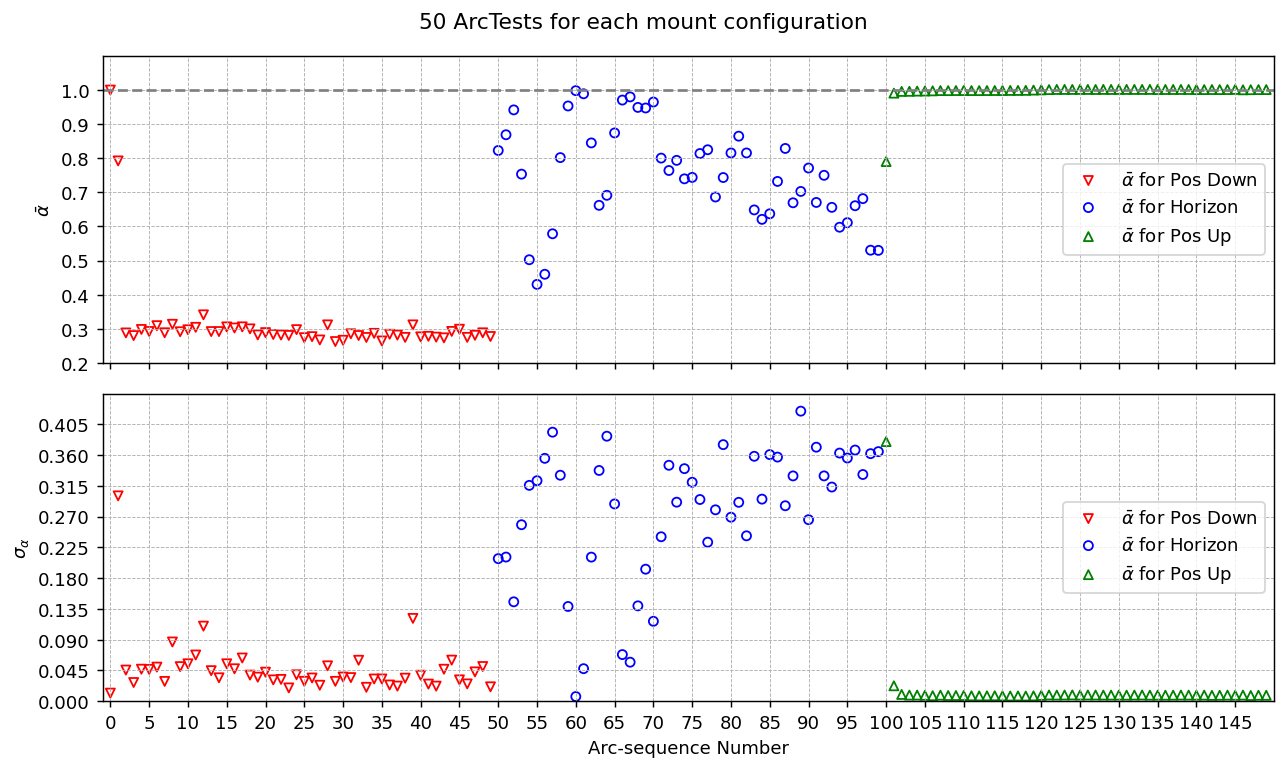

In [59]:
fig,axs = plt.subplots(2,1,figsize=[10,6], dpi=130,sharex=True)

fig.suptitle(title)

ylimit = [0.2,1.1]
ystep = 0.1

axs[0].grid(linestyle='--',linewidth=0.5)
axs[0].hlines(1,-1,len(np.unique(df['ArcSession']))+1,linestyle='--',colors='grey')
axs[0].set_xlim(-1,max(df['ArcSession'])+1)
axs[0].set_ylabel(r"$\bar{\alpha}$")
for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Mean Alpha"], return_index=True)
    mean_alpha_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[0].scatter(res2,mean_alpha_arr,label=r"$\bar{\alpha}$ for "+MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')
axs[0].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[0].set_ylim(ylimit[0],ylimit[1])
axs[0].legend(loc=5)

ylimit = [0,0.45]
ystep = (ylimit[1]-ylimit[0])/10

axs[1].grid(linestyle='--',linewidth=0.5)
axs[1].set_xlim(-1,max(df['ArcSession'])+1)
axs[1].set_xlabel("Arc-sequence Number")
axs[1].set_ylabel(r"$\sigma_{\alpha}}$")
axs[1].set_xticks(np.arange(0,len(np.unique(df['ArcSession'])),step=5))

for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Std Alpha"], return_index=True)
    mean_std_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[1].scatter(res2,mean_std_arr,label=r"$\bar{\alpha}$ for "+MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')

axs[1].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[1].set_ylim(ylimit[0],ylimit[1])
axs[1].legend(loc=5)

fig.tight_layout()

if save:
    plt.savefig(figPath+title+'.jpg',dpi=180)


In [106]:
niter = 50

save= False
title = '50 ArcTests for each mount configuration'

Transitions = np.array(['Positioner Down',"Horizon","Positioner Up"])
Transition_colors = np.array(['red','dodgerblue','green'])
pointmarkers = ["v",'o','^']
markersize = 25

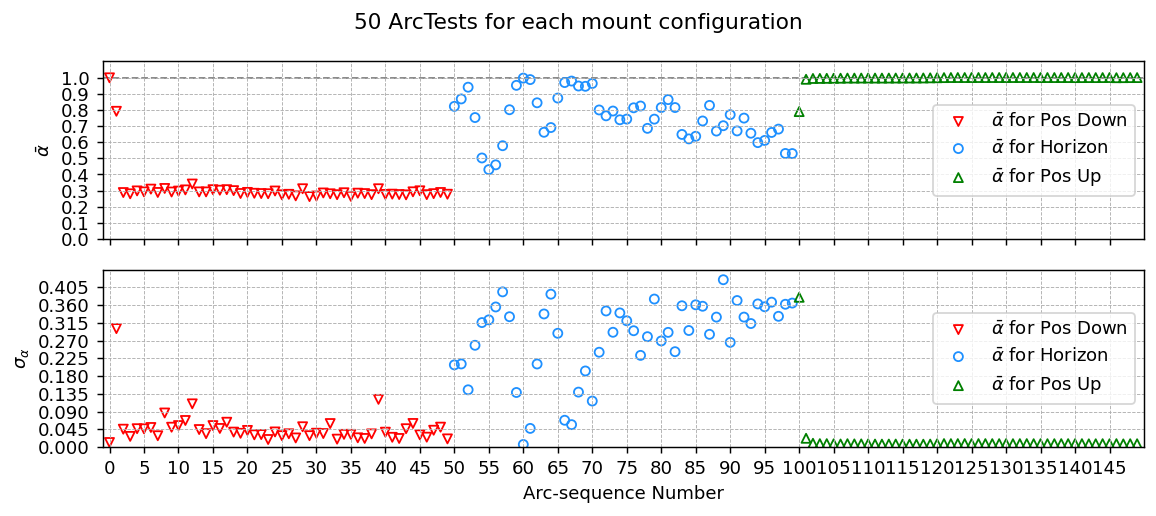

In [107]:
fig,axs = plt.subplots(2,1,figsize=[9,4], dpi=130,sharex=True)

fig.suptitle(title)

ylimit = [0.0,1.1]
ystep = 0.1

axs[0].grid(linestyle='--',linewidth=0.5)
axs[0].axhline(1, linestyle='--', zorder=0, lw=1, c='grey')

axs[0].set_xlim(-1, max(df['ArcSession'])+1)
axs[0].set_ylabel(r"$\bar{\alpha}$")
for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Mean Alpha"], return_index=True)
    mean_alpha_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[0].scatter(res2,mean_alpha_arr,label=r"$\bar{\alpha}$ for "+MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')
    
axs[0].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[0].set_ylim(ylimit[0],ylimit[1])
axs[0].legend(loc=5)

# -==========================
ylimit = [0,0.45]
ystep = (ylimit[1]-ylimit[0])/10

axs[1].grid(linestyle='--',linewidth=0.5)
axs[1].set_xlim(-1,max(df['ArcSession'])+1)
axs[1].set_xlabel("Arc-sequence Number")
axs[1].set_ylabel(r"$\sigma_{\alpha}}$")
axs[1].set_xticks(np.arange(0,len(np.unique(df['ArcSession'])),step=5))

for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Std Alpha"], return_index=True)
    mean_std_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[1].scatter(res2,mean_std_arr,label=r"$\bar{\alpha}$ for "+MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')

axs[1].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[1].set_ylim(ylimit[0],ylimit[1])
axs[1].legend(loc=5)

fig.tight_layout()

if save:
    plt.savefig(figPath+title+'.jpg',dpi=180)


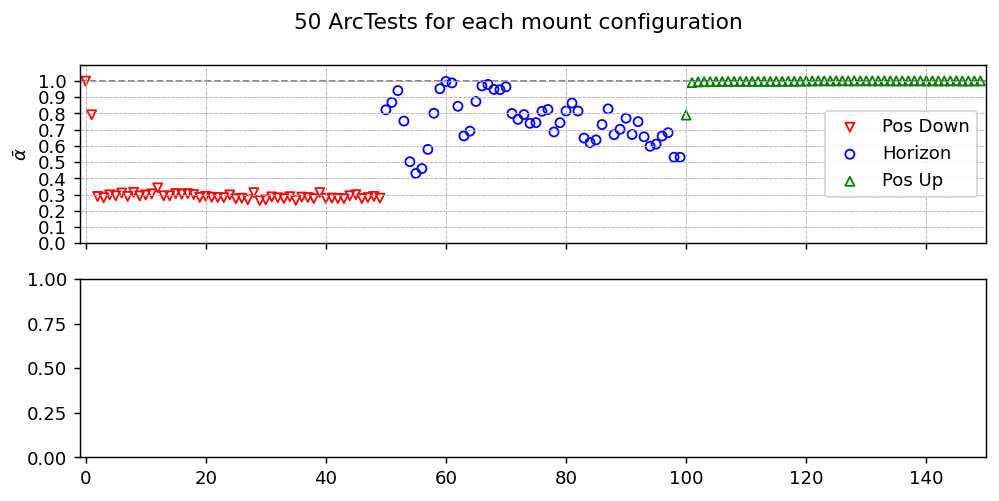

In [78]:
fig,axs = plt.subplots(2,1,figsize=[9,4], dpi=130,sharex=True)

fig.suptitle(title)

ylimit = [0.0,1.1]
ystep = 0.1

axs[0].grid(linestyle='--',linewidth=0.5)
axs[0].axhline(1, linestyle='--', zorder=0, lw=1, c='grey')

axs[0].set_xlim(-1, max(df['ArcSession'])+1)
axs[0].set_ylabel(r"$\bar{\alpha}$")
for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Mean Alpha"], return_index=True)
    mean_alpha_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[0].scatter(res2,mean_alpha_arr, label=MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')
    
axs[0].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[0].set_ylim(ylimit[0],ylimit[1])
axs[0].legend(loc=5)


Text(0.5, 0, 'Cycle Number')

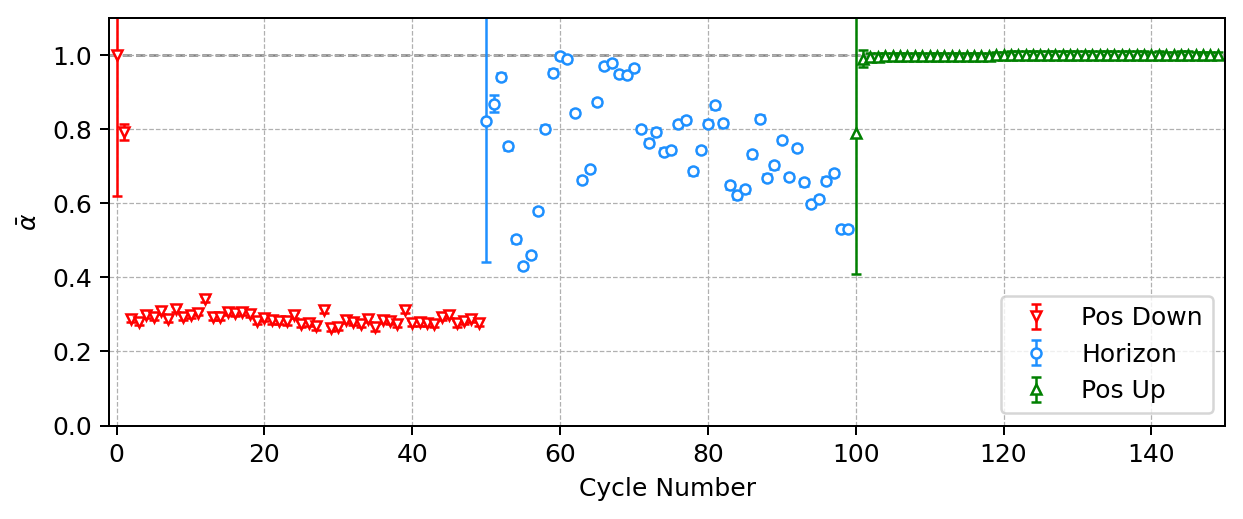

In [181]:
# fig,axs = plt.subplots(2,1,figsize=[9,4], dpi=130,sharex=True)

# fig.suptitle(title)
plt.figure(figsize=(8,3), dpi=180)
ylimit = [0.0,1.1]
ystep = 0.2

plt.grid(linestyle='--',linewidth=0.5)
plt.axhline(1, linestyle='--', zorder=0, lw=1, c='grey')

plt.xlim(-1, max(df['ArcSession'])+1)
plt.ylabel(r"$\bar{\alpha}$")

for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Mean Alpha"], return_index=True)
    mean_alpha_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    plt.errorbar(res2, mean_alpha_arr, yerr=mean_std_arr, 
                 label=MountConfigs[j],
                 fmt=pointmarkers[j], ms=4, capsize=2., lw=1, 
                 markerfacecolor='w', 
                color=Transition_colors[j])
    
plt.yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
plt.ylim(ylimit[0],ylimit[1])
plt.legend(loc='best')
plt.xlabel("Cycle Number")


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f306f24e9d0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f306f24e820>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f306f24e7f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f306f1ff190>}

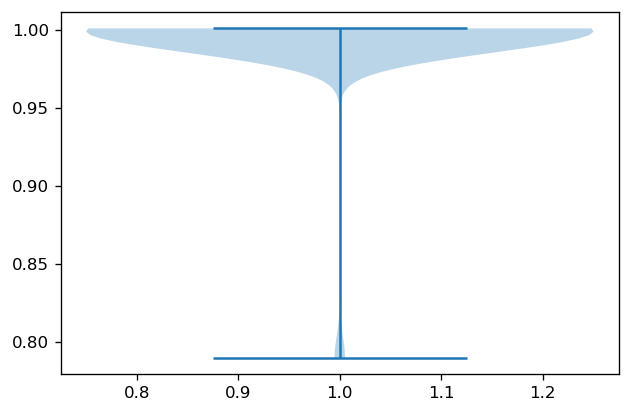

In [113]:
plt.violinplot(mean_alpha_arr)

In [114]:
df[msk]

,label,session,mtang1,mtang2,move,posid,direction,speed,motor,angle,...,yc2 mm,R2 mm,xc2 pix,yc2 pix,Mount Configuration,Alpha,Requested Move,Observed Move,Mean Alpha,Std Alpha
1700,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-151605,4852,cw,cruise,phi,0.0,...,33.230054,3.090608,1896.960149,940.823547,Pos Up,NaN,NaN,NaN,0.789660,0.379754
1701,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-151613,4852,cw,cruise,phi,15.0,...,33.230054,3.090608,1896.960149,940.823547,Pos Up,0.983220,17.09,16.803222,0.789660,0.379754
1702,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-151622,4852,cw,cruise,phi,15.0,...,33.230054,3.090608,1896.960149,940.823547,Pos Up,0.971394,18.99,18.446765,0.789660,0.379754
1703,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-151631,4852,cw,cruise,phi,15.0,...,33.230054,3.090608,1896.960149,940.823547,Pos Up,0.985885,18.99,18.721964,0.789660,0.379754
1704,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-151640,4852,cw,cruise,phi,15.0,...,33.230054,3.090608,1896.960149,940.823547,Pos Up,0.992918,18.99,18.855508,0.789660,0.379754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-172338,4852,ccw,cruise,phi,15.0,...,33.341172,3.077405,1898.456616,943.388240,Pos Up,0.999165,18.99,18.974137,1.000316,0.008608
2546,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-172348,4852,ccw,cruise,phi,15.0,...,33.341172,3.077405,1898.456616,943.388240,Pos Up,0.998180,18.99,18.955433,1.000316,0.008608
2547,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-172358,4852,ccw,cruise,phi,15.0,...,33.341172,3.077405,1898.456616,943.388240,Pos Up,0.998902,18.99,18.969150,1.000316,0.008608
2548,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-172408,4852,ccw,cruise,phi,15.0,...,33.341172,3.077405,1898.456616,943.388240,Pos Up,0.994657,18.99,18.888545,1.000316,0.008608


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f306efdf880>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f306efdf6a0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f306efdf6d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f306efdfd00>}

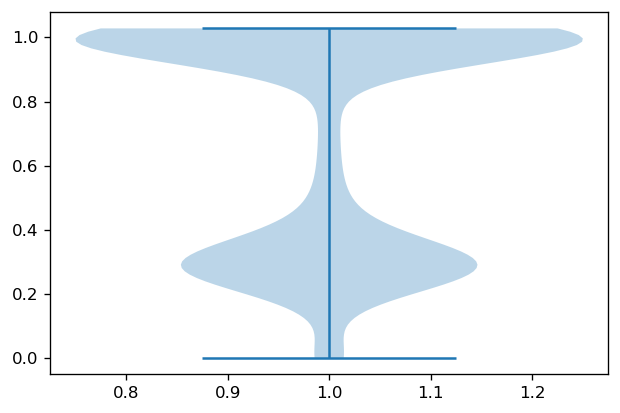

In [120]:
plt.violinplot(df['Alpha'].dropna())

In [152]:
ymax = 450
colors = ['red','dodgerblue','green']
x_hist_range = [0.2,1.1]
save=False
label = 'Histograms for 50 Iterations'
kwargs = dict(histtype='stepfilled', alpha=0.25, bins=40, range=(x_hist_range[0],x_hist_range[1])
             )
np.unique(df['Mount Configuration'])
mount_conf = [ 'Pos Down','Horizon', 'Pos Up']

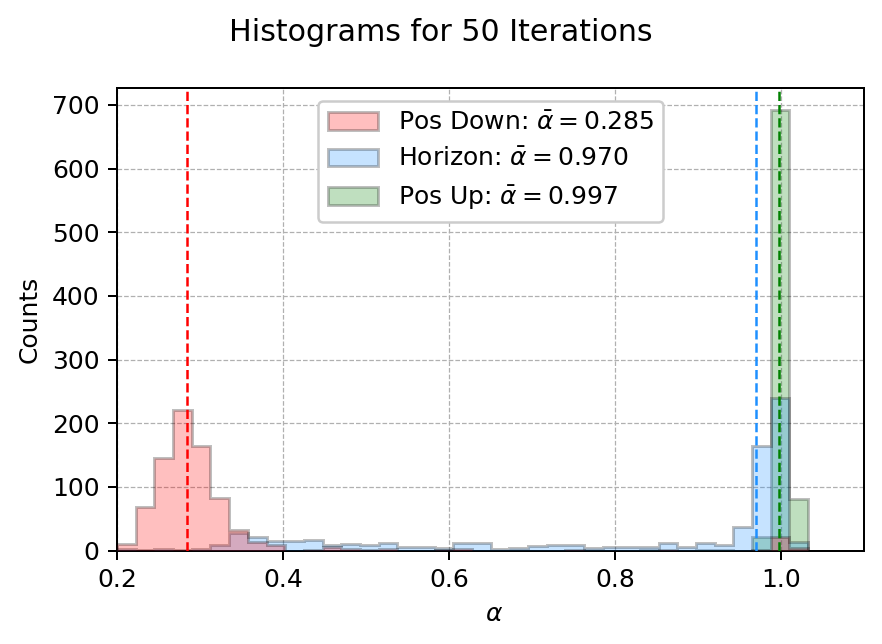

In [171]:
fig,ax = plt.subplots(figsize=[5,3.6], dpi=180)

fig.suptitle(label)
ax.grid(linestyle='--',linewidth=0.5)

for i, label_config in enumerate(mount_conf): #range(len(np.unique(df['Mount Configuration']))):
#     label_config = np.unique(df['Mount Configuration'])[i]
    med_val = np.nanmedian(df[df['Mount Configuration']==label_config]["Alpha"])
    
    ax.hist(df[df['Mount Configuration']==label_config]['Alpha'],
            color=colors[i], edgecolor='k', #colors[i], 
            linewidth=1.2,
            label=label_config+r': $\bar{\alpha} = $'+f'{med_val:.3f}', **kwargs, zorder=10-2*i)

    ax.axvline(med_val, lw=1, 
              linestyle='--',color=colors[i], zorder=15)
    
ax.legend(loc='best',framealpha=1)
ax.set_xlim(x_hist_range[0],x_hist_range[1])
ax.set_xlabel(r' $\alpha$')
ax.set_ylabel('Counts')

fig.tight_layout()

if save:
    plt.savefig(figPath+str(label)+'.jpg',dpi=180)

plt.show()